In [154]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import random
import numpy as np
import csv
import json
import copy
import os
import argparse
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [155]:
class InputExample:
    """Simple object to encapsulate each data example"""
    def __init__(self, src, trg, 
                 src_g, trg_g):    
        self.src = src
        self.trg = trg
        self.src_g = src_g
        self.trg_g = trg_g
    
    def __repr__(self):
        return str(self.to_json_str())
    
    def to_json_str(self):
        return json.dumps(self.to_dict(), indent=2, ensure_ascii=False)
    
    def to_dict(self):
        output = copy.deepcopy(self.__dict__)
        return output

In [156]:
class RawDataset:
    """Encapsulates the raw examples in InputExample objects"""
    def __init__(self, data_dir):
        self.train_examples = self.get_train_examples(data_dir)
        self.dev_examples = self.get_dev_examples(data_dir)
        self.test_examples = self.get_dev_examples(data_dir)
        
    def create_examples(self, src_path, trg_path):
        
        src_txt = self.get_txt_examples(src_path)
        src_gender_labels = self.get_labels(src_path + '.label')
        trg_txt = self.get_txt_examples(trg_path)
        trg_gender_labels = self.get_labels(trg_path + '.label')
        
        examples = []
        
        for i in range(len(src_txt)):
            src = src_txt[i].strip()
            trg = trg_txt[i].strip()
            src_g = src_gender_labels[i].strip()
            trg_g = trg_gender_labels[i].strip()
            input_example = InputExample(src, trg, src_g, trg_g)
            examples.append(input_example)
        
        return examples
    
    def get_labels(self, data_dir):
        with open(data_dir) as f:
            return f.readlines()
        
    def get_txt_examples(self, data_dir):
        with open(data_dir, encoding='utf8') as f:
            return f.readlines()
    
    def get_train_examples(self, data_dir):
        """Reads the train examples of the dataset"""
        return self.create_examples(os.path.join(data_dir, 'D-set-train.arin'), 
                                    os.path.join(data_dir, 'D-set-train.ar.M'))
    
    def get_dev_examples(self, data_dir):
        """Reads the dev examples of the dataset"""
        return self.create_examples(os.path.join(data_dir, 'D-set-dev.arin'), 
                                    os.path.join(data_dir, 'D-set-dev.ar.M'))
    
    def get_test_examples(self, data_dir):
        """Reads the test examples of the dataset"""
        return self.create_examples(os.path.join(data_dir, 'D-set-test.arin'), 
                                    os.path.join(data_dir, 'D-set-test.ar.M'))

In [157]:
class Vocabulary:
    """Base vocabulary class"""
    def __init__(self, token_to_idx=None):
        
        if token_to_idx is None:
            token_to_idx = dict()
        
        self.token_to_idx = token_to_idx
        self.idx_to_token = {idx: token for token, idx in self.token_to_idx.items()}
    
    def add_token(self, token):
        if token in self.token_to_idx:
            index = self.token_to_idx[token]
        else:
            index = len(self.token_to_idx)
            self.token_to_idx[token] = index
            self.idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        return [self.add_token(token) for token in tokens]
    
    def lookup_token(self, token):
        return self.token_to_idx[token]
    
    def lookup_index(self, index):
        return self.idx_to_token[index]
    
    def to_serializable(self):
        return {'token_to_idx': self.token_to_idx}
    
    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)
    
    def __len__(self):
        return len(self.token_to_idx)
    
class SeqVocabulary(Vocabulary):
    """Sequence vocabulary class"""
    def __init__(self, token_to_idx=None, unk_token='<unk>',
                 pad_token='<pad>', sos_token='<s>',
                 eos_token='</s>'):
        
        super(SeqVocabulary, self).__init__(token_to_idx)
        
        self.pad_token = pad_token
        self.unk_token = unk_token
        self.sos_token = sos_token
        self.eos_token = eos_token
        
        self.pad_idx = self.add_token(self.pad_token)
        self.unk_idx = self.add_token(self.unk_token)
        self.sos_idx = self.add_token(self.sos_token)
        self.eos_idx = self.add_token(self.eos_token)
        
    def to_serializable(self):
        contents = super(SeqVocabulary, self).to_serializable()
        contents.update({'unk_token': self.unk_token,
                         'pad_token': self.pad_token,
                         'sos_token': self.sos_token, 
                         'eos_token': self.eos_token})
        return contents
    
    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)
    
    def lookup_token(self, token):
        return self.token_to_idx.get(token, self.unk_idx)

In [158]:
class Vectorizer:
    """Vectorizer Class"""
    def __init__(self, src_vocab, trg_vocab):
        """src_vocab and trg_vocab are on the char
        level"""
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab
    
    @classmethod
    def create_vectorizer(cls, data_examples):
        """Class method which builds the vectorizer
        vocab"""
        
        src_vocab = SeqVocabulary()
        trg_vocab = SeqVocabulary()
        
        for ex in data_examples:
            src = ex.src
            trg = ex.trg
            
            for t in src:
                src_vocab.add_token(t)
                
            for t in trg:
                trg_vocab.add_token(t)
        
        return cls(src_vocab, trg_vocab)
    
    def get_src_indices(self, seq):
        """
        Args:
          - seq (str): The src sequence
        
        Returns:
          - indices (list): <s> + List of tokens to index mapping + </s>
        """
        indices = [self.src_vocab.sos_idx] 
        indices.extend([self.src_vocab.lookup_token(t) for t in seq])
        indices.append(self.src_vocab.eos_idx)
        return indices
    
    def get_trg_indices(self, seq):
        """
        Args:
          - seq (str): The trg sequence
        
        Returns:
          - trg_x_indices (list): <s> + List of tokens to index mapping
          - trg_y_indices (list): List of tokens to index mapping + </s>
        """
        indices = [self.trg_vocab.lookup_token(t) for t in seq]
        
        trg_x_indices = [self.trg_vocab.sos_idx] + indices
        trg_y_indices = indices + [self.trg_vocab.eos_idx]
        return trg_x_indices, trg_y_indices
        
    def vectorize(self, src, trg):
        """
        Args:
          - src (str): The src sequence
          - src (str): The trg sequence
        Returns:
          - vectorized_src 
          - vectorized_trg_x 
          - vectorized_trg_y
        """
        src = src
        trg = trg
        
        vectorized_src = self.get_src_indices(src)
        vectorized_trg_x, vectorized_trg_y = self.get_trg_indices(trg)
        
        return {'src': torch.tensor(vectorized_src, dtype=torch.long),
                'trg_x': torch.tensor(vectorized_trg_x, dtype=torch.long),
                'trg_y': torch.tensor(vectorized_trg_y, dtype=torch.long)
               }
    
    def to_serializable(self):
        return {'src_vocab': self.src_vocab.to_serializable(),
                'trg_vocab': self.trg_vocab.to_serializable()
               }
    
    @classmethod
    def from_serializable(cls, contents):
        src_vocab = SeqVocabulary.from_serializable(contents['src_vocab'])
        trg_vocab = SeqVocabulary.from_serializable(contents['trg_vocab'])
        return cls(src_vocab, trg_vocab)

In [159]:
class MT_Dataset(Dataset):
    """MT Dataset as a PyTorch dataset"""
    def __init__(self, raw_dataset, vectorizer):
        self.vectorizer = vectorizer
        self.train_examples = raw_dataset.train_examples
        self.dev_examples = raw_dataset.dev_examples
        self.test_examples = raw_dataset.test_examples
        self.lookup_split = {'train': self.train_examples,
                             'dev': self.dev_examples,
                             'test': self.test_examples}
        self.set_split('train')
    
    def get_vectorizer(self):
        return self.vectorizer
    
    @classmethod
    def load_data_and_create_vectorizer(cls, data_dir):
        raw_dataset = RawDataset(data_dir)
        # Note: we always create the vectorized based on the train examples
        vectorizer = Vectorizer.create_vectorizer(raw_dataset.train_examples)
        return cls(raw_dataset, vectorizer)
    
    @classmethod
    def load_data_and_load_vectorizer(cls, data_dir, vec_path):
        raw_dataset = RawDataset(data_dir)
        vectorizer = cls.load_vectorizer(vec_path)
        return cls(raw_dataset, vectorizer)
    
    @staticmethod
    def load_vectorizer(vec_path):
        with open(vec_path) as f:
            return Vectorizer.from_serializable(json.load(f))
    
    def save_vectorizer(self, vec_path):
        with open(vec_path, 'w') as f:
            return json.dump(self.vectorizer.to_serializable(), f)
        
    def set_split(self, split):
        self.split = split
        self.split_examples = self.lookup_split[self.split]
        return self.split_examples
    
    def __getitem__(self, index):
        example = self.split_examples[index]
        src, trg = example.src, example.trg
        vectorized = self.vectorizer.vectorize(src, trg)
        return vectorized
    
    def __len__(self):
        return len(self.split_examples)
    
    
class Collator:
    def __init__(self, src_pad_idx, trg_pad_idx):
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        
    def __call__(self, batch):
        # Sorting the batch by src seqs length in descending order
        sorted_batch = sorted(batch, key=lambda x: x['src'].shape[0], reverse=True)
        
        src_seqs = [x['src'] for x in sorted_batch]
        trg_x_seqs = [x['trg_x'] for x in sorted_batch]
        trg_y_seqs = [x['trg_y'] for x in sorted_batch]
        lengths = [len(seq) for seq in src_seqs]
        
        padded_src_seqs = pad_sequence(src_seqs, batch_first=True, padding_value=self.src_pad_idx)
        padded_trg_x_seqs = pad_sequence(trg_x_seqs, batch_first=True, padding_value=self.trg_pad_idx)
        padded_trg_y_seqs = pad_sequence(trg_y_seqs, batch_first=True, padding_value=self.trg_pad_idx)
        lengths = torch.tensor(lengths, dtype=torch.long)
        
        return {'src': padded_src_seqs,
                'trg_x': padded_trg_x_seqs,
                'trg_y': padded_trg_y_seqs,
                'src_lengths': lengths}

In [160]:
class Encoder(nn.Module):
    """Encoder biGRU"""
    def __init__(self, input_dim, embed_dim, 
                 hidd_dim, padding_idx=0):
        
        super(Encoder, self).__init__()
        self.embedding_layer = nn.Embedding(input_dim, embed_dim, padding_idx=padding_idx)
        self.rnn = nn.GRU(embed_dim, hidd_dim, batch_first=True, bidirectional=True)
        
    def forward(self, src_seqs, src_lengths):

        embedded_seqs = self.embedding_layer(src_seqs)

        packed_seqs = pack_padded_sequence(embedded_seqs, src_lengths, batch_first=True)
        
        output, h_t = self.rnn(packed_seqs)
        
        #output is a packed_sequence
        #h_t shape: [num_layers * num_dirs, batch_size, hidd_dim]
        
        #reshaping h_t to [batch_size, num_layers * num_dirs * hidd_dim]
    
        h_t = h_t.permute(1, 0, 2) #[batch_size, num_layers * num_dirs, hidd_dim]
        #Note: when we call permute, the contiguity of a tensor is lost,
        #so we have to call contiguous before reshaping!
        h_t = h_t.contiguous().view(h_t.shape[0], -1) #[batch_size, num_layers * num_dirs * hidd_dim]
        
        #unpacking output
        unpacked_output, lengths = pad_packed_sequence(output, batch_first=True)
        #output shape: [batch_size, src_seq_length, hidd_dim * num_dirs]
        
        return unpacked_output, h_t

In [161]:
class Decoder(nn.Module):
    """Decoder GRU
       
       Things to note:
           - The input to the decoder rnn at each time step is the 
             concatenation of the embedded token and the context vector
           - The context vector will have a size of batch_size, hidd_dim
           - Note that the decoder hidd_dim == the encoder hidd_dim * 2
           - The prediction layer input is the concatenation of 
             the context vector and the h_t of the decoder
    """
    
    def __init__(self, input_dim, embed_dim,
                 hidd_dim, output_dim,
                 attention,
                 padding_idx=0,
                 sos_idx=2,
                 eos_idx=3):
        
        super(Decoder, self).__init__()
        self.hidd_dim = hidd_dim
        self.sos_idx = sos_idx
        self.eos_idx = eos_idx
        self.attention = attention
        self.embedding_layer = nn.Embedding(input_dim, embed_dim, padding_idx=padding_idx)
        # the input to the rnn is the context_vector + embedded token --> embed_dim + hidd_dim
        self.rnn = nn.GRUCell(embed_dim + hidd_dim, hidd_dim)
        # the input to the classifier is h_t + context_vector --> hidd_dim * 2
        self.classifier = nn.Linear(hidd_dim * 2, output_dim)
        
        # sampling temperature
        self.sampling_temperature = 3
 
    def forward(self, trg_seqs, encoder_outputs, encoder_h_t, mask, 
                teacher_forcing_prob=0.3, 
                inference=False,
                max_len=200):
        
        # if we're doing inference
        if trg_seqs is None:
            teacher_forcing_prob = 0
            trg_seq_len = max_len
            batch_size = encoder_outputs.shape[0]
            inference = True
        else:
            # reshaping trg_seqs to: [trg_seq_len, batch_size]
            trg_seqs = trg_seqs.permute(1, 0)
            trg_seq_len, batch_size = trg_seqs.shape
        
        # initializing the context_vectors to zeros
        context_vectors = torch.zeros(batch_size, self.hidd_dim)
        # moving the context_vectors to the right device
        context_vectors = context_vectors.to(encoder_h_t.device)

        # initializing the hidden state to the encoder hidden state
        h_t = encoder_h_t
        
        # initializing the first trg input to the <sos> token
        y_t = torch.ones(batch_size, dtype=torch.long) * self.sos_idx
        # moving the y_t to the right device
        y_t = y_t.to(encoder_h_t.device)
        
        outputs = []
        self.attention_scores = []
        
        for i in range(trg_seq_len):
            
            teacher_forcing = np.random.random() < teacher_forcing_prob
                
            # Step 1: Concat the embedded token and the context_vectors
            embedded = self.embedding_layer(y_t)

            rnn_input = torch.cat((embedded, context_vectors), dim=1)
            
            # Step 2: Do a single RNN step and update the decoder hidden state
            h_t = self.rnn(rnn_input, h_t)
            
            # Step 3: Calculate attention and update context vectors
            context_vectors, attention_probs = self.attention(encoder_outputs, h_t, mask)
            
            # Step 4: Obtain the predicion vector
            prediction_vector = torch.cat((h_t, context_vectors), dim=1)
            
            # Step 5: Obtain the prediction output
            pred_output = self.classifier(prediction_vector)
           
            # if teacher_forcing, use ground truth target tokens
            # as an input to the decoder in the next time_step
            if teacher_forcing:
                y_t = trg_seqs[i]
                
            # If not teacher_forcing force, use the maximum 
            # prediction as an input to the decoder in 
            # the next time step
            if not teacher_forcing:
                # we multiply the predictions with a sampling_temperature
                # to make the propablities peakier, so we can be confident about the
                # maximum prediction
                pred_output_probs = F.softmax(pred_output * self.sampling_temperature, dim=1)
                y_t = torch.argmax(pred_output_probs, dim=1)

                # if we predicted the <eos> token stop decoding
                if inference and (y_t == self.eos_idx).sum() == y_t.shape[0]:
#                     print('inference')
                    break

            outputs.append(pred_output)
            self.attention_scores.append(attention_probs)
            
        outputs = torch.stack(outputs).permute(1, 0, 2)
        # outputs shape: [batch_size, trg_seq_len, output_dim]
        return outputs

In [162]:
class AdditiveAttention(nn.Module):
    """Attention mechanism as a MLP 
    as used by Bahdanau et. al 2015"""

    def __init__(self, encoder_hidd_dim, decoder_hidd_dim):
        super(AdditiveAttention, self).__init__()
        self.atten = nn.Linear((encoder_hidd_dim * 2) + decoder_hidd_dim, decoder_hidd_dim)
        self.v = nn.Linear(decoder_hidd_dim, 1)
        
    def forward(self, key_vectors, query_vector, mask):
        """key_vectors: encoder hidden states.
           query_vector: decoder hidden state at time t
           mask: the mask vector of zeros and ones
        """
        
        #key_vectors shape: [batch_size, src_seq_length, encoder_hidd_dim * 2]
        #query_vector shape: [batch_size, decoder_hidd_dim]
        #Note: encoder_hidd_dim * 2 == decoder_hidd_dim
        
        batch_size, src_seq_length, encoder_hidd_dim = key_vectors.shape
        
        #changing the shape of query_vector to [batch_size, src_seq_length, decoder_hidd_dim]
        #we will repeat the query_vector src_seq_length times at dim 1
        query_vector = query_vector.unsqueeze(1).repeat(1, src_seq_length, 1)
        
        # Step 1: Compute the attention scores through a MLP
        
        # concatenating the key_vectors and the query_vector
        atten_input = torch.cat((key_vectors, query_vector), dim=2)
        # atten_input shape: [batch_size, src_seq_length, (encoder_hidd_dim * 2) + decoder_hidd_dim]
        
        atten_scores = self.atten(atten_input)
        # atten_scores shape: [batch_size, src_seq_length, decoder_hidd_dim]

        atten_scores = torch.tanh(atten_scores)
    
        # mapping atten_scores from decoder_hidd_dim to 1
        atten_scores = self.v(atten_scores)
    
        # atten_scores shape: [batch_size, src_seq_length, 1]
        atten_scores = atten_scores.squeeze(dim=2)
        # atten_scores shape: [batch_size, src_seq_length]
        
        # masking the atten_scores
        atten_scores = atten_scores.masked_fill(mask == 0, -1e10)
        
        # Step 2: normalizing atten_scores through a softmax to get probs
        atten_scores = F.softmax(atten_scores, dim=1)
        
        # Step 3: computing the new context vector
        context_vectors = torch.matmul(key_vectors.permute(0, 2, 1), atten_scores.unsqueeze(2)).squeeze(dim=2)
        
        # context_vectors shape: [batch_size, encoder_hidd_dim * 2]
        
        return context_vectors, atten_scores
        

In [163]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder_input_dim, encoder_embed_dim,
                 encoder_hidd_dim, decoder_input_dim, decoder_embed_dim,
                 decoder_output_dim, src_padding_idx=0, trg_padding_idx=0):
    
        super(Seq2Seq, self).__init__()
        self.src_padding_idx = src_padding_idx
        self.encoder = Encoder(input_dim=encoder_input_dim,
                               embed_dim=encoder_embed_dim,
                               hidd_dim=encoder_hidd_dim,
                               padding_idx=src_padding_idx)

        decoder_hidd_dim = encoder_hidd_dim * 2 
        
        self.attention = AdditiveAttention(encoder_hidd_dim=encoder_hidd_dim,
                                           decoder_hidd_dim=decoder_hidd_dim)
        
        self.decoder = Decoder(input_dim=decoder_input_dim,
                               embed_dim=decoder_embed_dim,
                               hidd_dim=decoder_hidd_dim,
                               output_dim=decoder_output_dim,
                               attention=self.attention,
                               padding_idx=trg_padding_idx)
    
    def create_mask(self, src_seqs, src_padding_idx):
        mask = (src_seqs != src_padding_idx)
        # mask shape: [batch_size, src_seq_length]
        return mask 
    
    def forward(self, src_seqs, src_seqs_lengths, trg_seqs, teacher_forcing_prob=0.3):
        encoder_output, encoder_h_t = self.encoder(src_seqs, src_seqs_lengths)
        mask = self.create_mask(src_seqs, self.src_padding_idx)
        decoder_output = self.decoder(trg_seqs, encoder_output, encoder_h_t, mask, 
                                      teacher_forcing_prob=teacher_forcing_prob)
        return decoder_output

In [164]:
def set_seed(seed, cuda):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed(seed)

In [165]:
args = argparse.Namespace(data_dir='/home/ba63/gender-bias/data/christine_2019/Arabic-parallel-gender-corpus',
                          vectorizer_path='/home/ba63/gender-bias/models/saved_models/char_level_vectorizer.json',
                          reload_files=False,
                          cache_files=False,
                          num_epochs=50,
                          embedding_dim=32,
                          hidd_dim=64,
                          learning_rate=5e-4,
                          use_cuda=True,
                          batch_size=64,
                          seed=21,
                          model_path='/home/ba63/gender-bias/models/saved_models/char_level_model_small_old.pt'
                          )

device = torch.device('cuda' if args.use_cuda else 'cpu')
set_seed(args.seed, args.use_cuda)

In [166]:
if args.reload_files:
    dataset = MT_Dataset.load_data_and_load_vectorizer(args.data_dir, args.vectorizer_path)
else:
    dataset = MT_Dataset.load_data_and_create_vectorizer(args.data_dir)

if args.cache_files:
    dataset.save_vectorizer(args.vectorizer_path)

vectorizer = dataset.get_vectorizer()
ENCODER_INPUT_DIM = len(vectorizer.src_vocab)
DECODER_INPUT_DIM = len(vectorizer.trg_vocab)
DECODER_OUTPUT_DIM = len(vectorizer.trg_vocab)
SRC_PAD_INDEX = vectorizer.src_vocab.pad_idx
TRG_PAD_INDEX = vectorizer.trg_vocab.pad_idx

In [167]:
model = Seq2Seq(encoder_input_dim=ENCODER_INPUT_DIM,
                encoder_embed_dim=args.embedding_dim,
                encoder_hidd_dim=args.hidd_dim,
                decoder_input_dim=DECODER_INPUT_DIM,
                decoder_embed_dim=args.embedding_dim,
                decoder_output_dim=DECODER_OUTPUT_DIM,
                src_padding_idx=SRC_PAD_INDEX,
                trg_padding_idx=TRG_PAD_INDEX)

optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_INDEX)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                 patience=2, factor=0.5)
model

Seq2Seq(
  (encoder): Encoder(
    (embedding_layer): Embedding(71, 32, padding_idx=0)
    (rnn): GRU(32, 64, batch_first=True, bidirectional=True)
  )
  (attention): AdditiveAttention(
    (atten): Linear(in_features=256, out_features=128, bias=True)
    (v): Linear(in_features=128, out_features=1, bias=True)
  )
  (decoder): Decoder(
    (attention): AdditiveAttention(
      (atten): Linear(in_features=256, out_features=128, bias=True)
      (v): Linear(in_features=128, out_features=1, bias=True)
    )
    (embedding_layer): Embedding(71, 32, padding_idx=0)
    (rnn): GRUCell(160, 128)
    (classifier): Linear(in_features=256, out_features=71, bias=True)
  )
)

In [168]:
def train(model, dataloader, optimizer, criterion, device='cpu', teacher_forcing_prob=1):
    model.train()
    epoch_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        src = batch['src']
        trg_x = batch['trg_x']
        trg_y = batch['trg_y']
        src_lengths = batch['src_lengths']
        
        preds = model(src_seqs=src, 
                      src_seqs_lengths=src_lengths, 
                      trg_seqs=trg_x,
                      teacher_forcing_prob=teacher_forcing_prob)
        
        # CrossEntropysLoss accepts matrices always! 
        # the preds must be of size (N, C) where C is the number 
        # of classes and N is the number of samples. 
        # The ground truth must be a Vector of size C!
        preds = preds.contiguous().view(-1, preds.shape[-1])
        trg_y = trg_y.view(-1)

        loss = criterion(preds, trg_y)
        epoch_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    return epoch_loss / len(dataloader)


def evaluate(model, dataloader, criterion, device='cpu', teacher_forcing_prob=0):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            src = batch['src']
            trg_x = batch['trg_x']
            trg_y = batch['trg_y']
            src_lengths = batch['src_lengths']

            preds = model(src_seqs=src, 
                          src_seqs_lengths=src_lengths, 
                          trg_seqs=trg_x,
                          teacher_forcing_prob=teacher_forcing_prob)
            # CrossEntropyLoss accepts matrices always! 
            # the preds must be of size (N, C) where C is the number 
            # of classes and N is the number of samples. 
            # The ground truth must be a Vector of size C!
            preds = preds.contiguous().view(-1, preds.shape[-1])
            trg_y = trg_y.view(-1)
            
            loss = criterion(preds, trg_y)
            epoch_loss += loss.item()
            
    return epoch_loss / len(dataloader)

In [17]:
model = model.to(device)
collator = Collator(SRC_PAD_INDEX, TRG_PAD_INDEX)
best_loss = 1e10
set_seed(args.seed, args.use_cuda)
train_losses = []
dev_losses = []
print(f'Using {device}')
for epoch in range(args.num_epochs):
#     teacher_forcing_prob = (epoch + 5) / args.num_epochs
    teacher_forcing_prob = 0.3
    dataset.set_split('train')
    dataloader = DataLoader(dataset, shuffle=True, batch_size=args.batch_size, collate_fn=collator)

    train_loss = train(model, dataloader, optimizer, criterion, device, teacher_forcing_prob=teacher_forcing_prob)
    train_losses.append(train_loss)
    
    dataset.set_split('dev')
    dataloader = DataLoader(dataset, shuffle=True, batch_size=args.batch_size, collate_fn=collator)
    dev_loss = evaluate(model, dataloader, criterion, device, teacher_forcing_prob=0)
    dev_losses.append(dev_loss)
    
    #save best model
    if dev_loss < best_loss:
        best_loss = dev_loss
        torch.save(model.state_dict(), args.model_path)
    
    scheduler.step(dev_loss)
    print(f'Epoch: {(epoch + 1)}')
    print(f'\tTrain Loss: {train_loss:.4f}   |   Dev Loss: {dev_loss:.4f}')

Using cuda
Epoch: 1
	Train Loss: 3.2415   |   Dev Loss: 3.0688
Epoch: 2
	Train Loss: 2.9470   |   Dev Loss: 2.8220
Epoch: 3
	Train Loss: 2.5902   |   Dev Loss: 2.3429
Epoch: 4
	Train Loss: 2.0554   |   Dev Loss: 2.0095
Epoch: 5
	Train Loss: 1.6389   |   Dev Loss: 1.4887
Epoch: 6
	Train Loss: 1.3309   |   Dev Loss: 1.2902
Epoch: 7
	Train Loss: 1.1873   |   Dev Loss: 1.1114
Epoch: 8
	Train Loss: 0.9806   |   Dev Loss: 0.9340
Epoch: 9
	Train Loss: 0.9272   |   Dev Loss: 0.8981
Epoch: 10
	Train Loss: 0.7595   |   Dev Loss: 0.8519
Epoch: 11
	Train Loss: 0.7518   |   Dev Loss: 0.7573
Epoch: 12
	Train Loss: 0.6458   |   Dev Loss: 0.6025
Epoch: 13
	Train Loss: 0.6002   |   Dev Loss: 0.5895
Epoch: 14
	Train Loss: 0.6244   |   Dev Loss: 1.0837
Epoch: 15
	Train Loss: 0.5173   |   Dev Loss: 0.6251
Epoch: 16
	Train Loss: 0.5366   |   Dev Loss: 0.8801
Epoch: 17
	Train Loss: 0.3973   |   Dev Loss: 0.6253
Epoch: 18
	Train Loss: 0.3821   |   Dev Loss: 0.4666
Epoch: 19
	Train Loss: 0.4356   |   Dev Loss

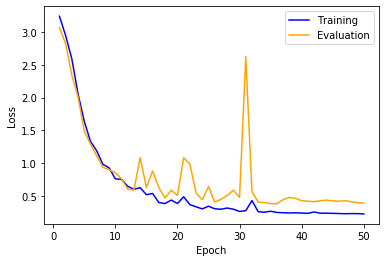

In [18]:
plt.plot(range(1, 1 + args.num_epochs), np.asarray(train_losses), 'b-', color='blue', label='Training')
plt.plot(range(1, 1 + args.num_epochs), np.asarray(dev_losses), 'b-', color='orange', label='Evaluation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [169]:
class NMT_Batch_Sampler:
    def __init__(self, model, src_vocab, trg_vocab):
        self.model = model
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab
    
    def update_batch(self, batch):
        self.sample_batch = batch
        
        src = batch['src']

        trg_x = batch['trg_x']
        trg_y = batch['trg_y']
        src_lengths = batch['src_lengths']

        preds = self.model(src, src_lengths, trg_x, teacher_forcing_prob=0)
        # preds shape: [batch_size, trg_seq_len, output_dim]
        
        attention_scores = [score.cpu().detach() for score in self.model.decoder.attention_scores]
        # len(attention_scores): trg_seq_len
        # each vector in attention_scores has a shape: [batch_size, src_seq_len]
        attention_scores = torch.stack(attention_scores)
        attention_scores = attention_scores.permute(1, 0, 2)
        # attention_score shape: [batch_size, trg_seq_len, src_seq_len]
        
        self.sample_batch['preds'] = preds
        self.sample_batch['attention_scores'] = attention_scores
        return self.sample_batch
    
    def get_pred_sentence(self, index):
        preds = self.sample_batch['preds']
       
        max_preds = torch.argmax(preds, dim=2)
        # max_preds shape: [batch_size, trg_seq_len]
        max_pred_sentence = max_preds[index].cpu().detach().numpy()
        return self.get_str_sentence(max_pred_sentence, self.trg_vocab)
    
    def get_trg_sentence(self, index):
        trg_sentence = self.sample_batch['trg_y'][index].cpu().detach().numpy()
        return self.get_str_sentence(trg_sentence, self.trg_vocab)
    
    def get_src_sentence(self, index):
        src_sentence = self.sample_batch['src'][index].cpu().detach().numpy()
        return self.get_str_sentence(src_sentence, self.src_vocab)
    
    def get_str_sentence(self, vectorized_sentence, vocab):
        sentence = []
        for i in vectorized_sentence:
            if i == vocab.sos_idx:
                continue
            elif i == vocab.eos_idx:
                break
            else:
                sentence.append(vocab.lookup_index(i))
        return ''.join(sentence)

    def translate_sentence(self, sentence):
        """Args:
            - sentence (string): sentence to be translated
           Returns:
            - translated sentence (string)
        """

        model.eval()

        # vectorizing the sentence
        vectorized_src_sentence = [self.src_vocab.sos_idx]
        vectorized_src_sentence.extend([self.src_vocab.lookup_token(t) for t in sentence])
        vectorized_src_sentence.append(self.src_vocab.eos_idx)

        # getting sentence length
        src_sentence_length = len(vectorized_src_sentence)

        # converting the vectorized sentence and the length to tensors
        vectorized_src_sentence = torch.tensor([vectorized_src_sentence], dtype=torch.long)
        src_sentence_length = torch.tensor([src_sentence_length], dtype=torch.long)

        vectorized_src_sentence = vectorized_src_sentence.to(device)
        src_sentence_length = src_sentence_length.to(device)

        with torch.no_grad():
            decoder_output = self.model(src_seqs=vectorized_src_sentence, 
                                        src_seqs_lengths=src_sentence_length, 
                                        trg_seqs=None, teacher_forcing_prob=0)

        
        max_preds = torch.argmax(decoder_output, dim=2).squeeze().cpu().detach().tolist()
        
        max_preds = [max_preds] if isinstance(max_preds, int) else max_preds
        str_sentence = self.get_str_sentence(max_preds, self.trg_vocab)
        
        return str_sentence

In [170]:
set_seed(args.seed, args.use_cuda)
dataset.set_split('train')
model.load_state_dict(torch.load(args.model_path))
device = torch.device('cpu')
model = model.to(device)
model.eval()
collator = Collator(SRC_PAD_INDEX, TRG_PAD_INDEX)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collator)
sampler = NMT_Batch_Sampler(model, vectorizer.src_vocab, vectorizer.trg_vocab)

In [171]:
train_preds = open(
    '/home/ba63/gender-bias/data/christine_2019/Arabic-parallel-gender-corpus/'\
    'edits_annotations/char_level_model_small_old.train_preds', 'w')

In [172]:
train_preds_inf = open(
    '/home/ba63/gender-bias/data/christine_2019/Arabic-parallel-gender-corpus/'\
    'edits_annotations/char_level_model_small_old.train_preds.inf', 'w')

In [173]:
train_log = open(
    '/home/ba63/gender-bias/data/christine_2019/Arabic-parallel-gender-corpus/'\
    'edits_annotations/char_level_model_small_old.train_log.inf', 'w')

In [174]:
for batch in dataloader:
    updated_batch = sampler.update_batch(batch)

#     print(updated_batch['trg_x'])
#     print(updated_batch['trg_y'])
#     print(updated_batch['src'])
    src = sampler.get_src_sentence(0)
    trg = sampler.get_trg_sentence(0)
    pred = sampler.get_pred_sentence(0)
    translated = sampler.translate_sentence(src)
    
#     print(src)
#     print(trg)
#     print(pred)
#     print(translated)
#     print(len(translated))
    
    train_log.write(f'src: ' + src)
    train_log.write('\n')
    train_log.write(f'trg: ' + trg)
    train_log.write('\n')
    train_log.write(f'pred: ' + pred)
    train_log.write('\n')
    train_log.write(f'trans: ' + translated)
    train_log.write('\n\n')
    train_preds.write(pred)
    train_preds.write('\n')
    train_preds_inf.write(translated)
    train_preds_inf.write('\n')
#     attention_scores = updated_batch['attention_scores'][0].cpu().detach().numpy()
#     fig = plt.figure(figsize=(10,10))
#     ax = fig.add_subplot(111)
#     cax = ax.matshow(attention_scores, cmap='bone')
#     fig.colorbar(cax)

#     # Set up axes
#     ax.set_xticklabels(['','<s>'] + src.split(' ') +
#                    ['</s>'], rotation=90)
#     ax.set_yticklabels([''] + pred.split(' ') + ['</s>'])

#     # Show label at every tick
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     plt.show()

train_log.close()
train_preds.close()
train_preds_inf.close()
#     break

In [55]:
for batch in dataloader:
    updated_batch = sampler.update_batch(batch)

#     print(updated_batch['trg_x'])
#     print(updated_batch['trg_y'])
#     print(updated_batch['src'])
    src = sampler.get_src_sentence(0)
    trg = sampler.get_trg_sentence(0)
    pred = sampler.get_pred_sentence(0)
    translated = sampler.translate_sentence(src)
    
    if translated != pred:
        print(f'src: ' + src)
        print(f'trg: ' + trg)
        print(f'pred: ' + pred)
        print(f'trans: ' + translated)
#     print(src)
#     print(trg)
#     print(pred)
#     print(translated)
#     print(len(translated))
    
#     attention_scores = updated_batch['attention_scores'][0].cpu().detach().numpy()
#     fig = plt.figure(figsize=(10,10))
#     ax = fig.add_subplot(111)
#     cax = ax.matshow(attention_scores, cmap='bone')
#     fig.colorbar(cax)

#     # Set up axes
#     ax.set_xticklabels(['','<s>'] + src.split(' ') +
#                    ['</s>'], rotation=90)
#     ax.set_yticklabels([''] + pred.split(' ') + ['</s>'])

#     # Show label at every tick
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     plt.show()

train_log.close()
train_preds.close()
train_preds_inf.close()
#     break

inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
src: لذا ، فرانك هو في السجن ، والجميع تراجعت إلى أركانها ، بما في ذلك بلدي الرؤساء ، واحد منهم قد قال مرارا لي لندعه يذهب والمضي قدما .
trg: لذا ، فرانك هو في السجن ، والجميع تراجعت إلى أركانها ، بما في ذلك بلدي الرؤساء ، واحد منهم قد قال مرارا لي لندعه يذهب والمضي قدما .
pred: لذا ، فرانك هو في السجن ، والجميع تراععت إلى  لناا       ل  ل ل لل ل لا ل ال ا ا ا ا ا  ا     ا          لد   لد   نهه  اها  لمضي قد
trans: لذا ، فرانك هو في السجن ، والجميع تراععت إلى  لناا       ل  ل ل لل ل لا ل ال ا ا ا ا ا  ا     ا          لد   لد   نهه  اها  لمضي قدم  
inference
inference
inference
inference
inference
inference
infe

inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference


inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
src: المشكلة هي هذه الأنابيب هي تقريبا 73 مرات قطر ، مثل . . . طول جناحيها بلدي .
trg: المشكلة هي هذه الأنابيب هي تقريبا 73 مرات قطر ، مثل . . . طول جناحيها بلدي .
pred: المشكلة هي هذه الأنابيب هي تقريبا    مرا  قط     ث   .. ..  طول جنحيهاا بلدي 
trans: المشكلة هي هذه الأنابيب هي تقريبا    مرا  قط     ث   .. ..  طول جنحيهاا بلدي .
inference
inference
inference
inference
inference
inference
infere

inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference


inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference


inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference


inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference


inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
src: حصلت على طابع بموافقة منها وأنا من المفضل أن أسمر باقة الجراء على الأرض وبعد ذلك ابدأ بسحقهم و إسحق جماجمهم بحافلة حملتي .
trg: حصلت على طابع بموافقة منها وأنا من المفضل أن أسمر باقة الجراء على الأرض وبعد ذلك ابدأ بسحقهم و إسحق جماجمهم بحافلة حملتي .
pred: حصلت على طابع بموافقة منها وأنا من اممفض أأن  اما ااارا  للرل  لل لب   بد  بدب  بد بسق  سح  سح  سحم  جممممممبمامح حللل  لمت
trans: حصلت على طابع بموافقة منها وأنا من اممفض أأن  اما ااارا  للرل  لل لب   بد  بدب  بد بسق  سح  سح  سحم  جممممممبمامح حللل  لمتي .
inference
inference
inference
inference
inference
inference
inference
inference


inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference


inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference


inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
src: إذهبي و إجلبي ( جيم ) إلي - هذه الربطة إختيرت إلي - ( من قبل مختصين في ( تينفلاي ، نيوجيرسي و إختاروها من بين 56 ربطة أخرى
trg: إذهبي و إجلبي ( جيم ) إلي - هذه الربطة إختيرت إلي - ( من قبل مختصين في ( تينفلاي ، نيوجيرسي و إختاروها من بين 56 ربطة أخرى
pred: إذهبي و إجلبي ( جيم ) إلي - هذه الربطة إختيي                 يتييينييييييي ييي ييويي  ويروي  ورو  ورو     ن بن  ن    ر ر رب
trans: إذهبي و إجلبي ( جيم ) إلي - هذه الربطة إختيي                 يتييينييييييي ييي ييويي  ويروي  ورو  ورو     ن بن  ن    ر ر رب رخرر
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inferenc

inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference


inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
src: - مرحبا ، أنا امرأة ناضجة عمليا .
trg: - مرحبا ، أنا رجل ناضج عمليا .
pred: - مرحبا ، أنا امرأة نضجة عمليا 
trans: - مرحبا ، أنا امرأة نضجة عمليا .
inference
inference
inference
inference
inference
inference
src: وهذا جعلني اتخذ القرار الصعب والضروري في نفس الوقت . . . . . . ان اتنحى مؤقتا كرئيسة وزراء واركز جهدي لابنتي وعائلتي
trg: وهذا جعلني اتخذ القرار الصعب والضروري في

inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
src: حسنا أنا امرأة أنا التي تعاني من عدم العدالة
trg: حسنا أنا رجل انا الذي يعاني من عدم العدالة
pred: حسنا أنا امرأ  أاا التي تعاني من عدم العدال
trans: حسنا أنا امرأ  أاا التي تعاني من عدم العدالة
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference
inference


In [175]:
set_seed(args.seed, args.use_cuda)
dataset.set_split('dev')
model.load_state_dict(torch.load(args.model_path))
device = torch.device('cpu')
model = model.to(device)
model.eval()
collator = Collator(SRC_PAD_INDEX, TRG_PAD_INDEX)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collator)
sampler = NMT_Batch_Sampler(model, vectorizer.src_vocab, vectorizer.trg_vocab)

In [176]:
dev_preds = open(
    '/home/ba63/gender-bias/data/christine_2019/Arabic-parallel-gender-corpus/'\
    'edits_annotations/char_level_model_small_old.dev_preds', 'w')

In [177]:
dev_preds_inf = open(
    '/home/ba63/gender-bias/data/christine_2019/Arabic-parallel-gender-corpus/'\
    'edits_annotations/char_level_model_small_old.dev_preds.inf', 'w')

In [178]:
dev_log = open(
    '/home/ba63/gender-bias/data/christine_2019/Arabic-parallel-gender-corpus/'\
    'edits_annotations/char_level_model_small_old.dev_log.inf', 'w')

In [179]:
for batch in dataloader:
    updated_batch = sampler.update_batch(batch)

#     print(updated_batch['trg_x'])
#     print(updated_batch['trg_y'])
#     print(updated_batch['src'])
    src = sampler.get_src_sentence(0)
    trg = sampler.get_trg_sentence(0)
    pred = sampler.get_pred_sentence(0)
    translated = sampler.translate_sentence(src)
#     print(src)
#     print(trg)
#     print(pred)
    
    dev_log.write(f'src: ' + src)
    dev_log.write('\n')
    dev_log.write(f'trg: ' + trg)
    dev_log.write('\n')
    dev_log.write(f'pred: ' + pred)
    dev_log.write('\n')
    dev_log.write(f'trans: ' + translated)
    dev_log.write('\n\n')
    dev_preds.write(pred)
    dev_preds.write('\n')
    dev_preds_inf.write(translated)
    dev_preds_inf.write('\n')
#     attention_scores = updated_batch['attention_scores'][0].cpu().detach().numpy()
#     fig = plt.figure(figsize=(10,10))
#     ax = fig.add_subplot(111)
#     cax = ax.matshow(attention_scores, cmap='bone')
#     fig.colorbar(cax)

#     # Set up axes
#     ax.set_xticklabels(['','<s>'] + src.split(' ') +
#                    ['</s>'], rotation=90)
#     ax.set_yticklabels([''] + pred.split(' ') + ['</s>'])

#     # Show label at every tick
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     plt.show()

#     break

dev_log.close()
dev_preds.close()
dev_preds_inf.close()